In [4]:
import os
import shutil
os.environ['USE_PYGEOS'] = '0'
os.environ['PROJ_LIB'] = '/opt/conda/share/proj/'
os.environ['NUMEXPR_MAX_THREADS'] = '48'
os.environ['NUMEXPR_NUM_THREADS'] = '48'
os.environ['OMP_THREAD_LIMIT'] = '48'
os.environ["OMP_NUM_THREADS"] = "48"
os.environ["OPENBLAS_NUM_THREADS"] = "48" # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "48" # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "48" # export VECLIB_MAXIMUM_THREADS=4
import gc
from datetime import datetime
from osgeo import gdal, gdal_array
from pathlib import Path
from typing import Callable, Iterator, List,        Union
import bottleneck as bn
import geopandas as gpd
import numpy as np
import pandas as pd
import skmap_bindings
import tempfile
import time
import sys
import csv
from scipy.signal import savgol_coeffs
import numpy as np
from skmap.io import process
import matplotlib.pyplot as plt

gdal_opts = {
 'GDAL_HTTP_VERSION': '1.0',
 'CPL_VSIL_CURL_ALLOWED_EXTENSIONS': '.tif',
}

co = ['TILED=YES', 'BIGTIFF=YES', 'COMPRESS=DEFLATE', 'BLOCKXSIZE=1024', 'BLOCKYSIZE=1024']

executor = None

def ttprint(*args, **kwargs):
    from datetime import datetime
    import sys

    print(f'[{datetime.now():%H:%M:%S}] ', end='')
    print(*args, **kwargs, flush=True)

def make_tempdir(basedir='skmap', make_subdir = True):
    tempdir = Path(TMP_DIR).joinpath(basedir)
    if make_subdir: 
        name = Path(tempfile.NamedTemporaryFile().name).name
        tempdir = tempdir.joinpath(name)
    tempdir.mkdir(parents=True, exist_ok=True)
    return tempdir

def make_tempfile(basedir='skmap', prefix='', suffix='', make_subdir = False):
    tempdir = make_tempdir(basedir, make_subdir=make_subdir)
    return tempdir.joinpath(
        Path(tempfile.NamedTemporaryFile(prefix=prefix, suffix=suffix).name).name
    )
    
x_size, y_size = (4800, 4800)
x_off, y_off = (0,0)
n_threads = 48
no_data, delc, mod_decl, stress, stable, incr = (0, 1, 2, 3, 4, 5)
bands_list = [1,]

base_raseter = ['/home/dconsoli/Desktop/veg_ndvi_mod13q1.v061_p50_250m_s0..0cm_2023.01.01..2023.01.31_v2.tif',]
out_raseter = ['test_Mirova_prod_subind',]


In [5]:
ttprint(f"Processing file {base_raseter[0]}")

in_data = np.empty((1, x_size * y_size), dtype=np.float32)

start = time.time()
skmap_bindings.readData(in_data, n_threads, base_raseter, range(len(base_raseter)), x_off, y_off, x_size, y_size, bands_list, gdal_opts)
ttprint(f"Reading data: {(time.time() - start):.2f} segs")

start = time.time()
out_data = in_data.copy()
# Some random example to get compilant with the required format
out_data[in_data>8000] = incr
out_data[out_data>6000] = stable
out_data[out_data>4000] = stress
out_data[out_data>2000] = mod_decl
out_data[in_data<=2000] = delc
out_data[in_data==-3000] = no_data
ttprint(f"Processing data: {(time.time() - start):.2f} segs")


start = time.time()
skmap_bindings.writeByteData(out_data, n_threads, gdal_opts, base_raseter[0:len(out_raseter)], f'/home/dconsoli/Desktop', out_raseter, range(len(out_raseter)),
    x_off, y_off, x_size, y_size, 0)
ttprint(f"Saving data: {(time.time() - start):.2f} segs")


[07:37:19] Processing file /home/dconsoli/Desktop/veg_ndvi_mod13q1.v061_p50_250m_s0..0cm_2023.01.01..2023.01.31_v2.tif
[07:37:19] Reading data: 0.18 segs
[07:37:19] Processing data: 0.24 segs
[07:37:19] Saving data: 0.09 segs


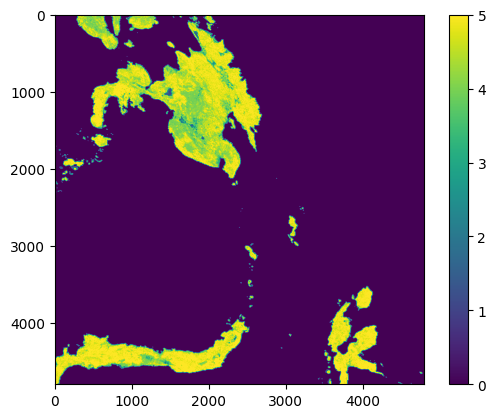

In [6]:
plt.imshow(np.reshape(out_data[0],(x_size, y_size)))
plt.colorbar()
plt.show()